In [1]:
from plots.mpltoolkit import named_colors, mpl_loc, markers, fancy_legend, load_mpl_presets
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np
import random
import vice
import sys
sys.path.append("..")
from src.stats import skewnormal_mode_sample, jackknife_summary_statistic
load_mpl_presets()
mpl.rcParams["axes.linewidth"] = 0.5
mpl.rcParams["figure.titlesize"] = 14
mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["axes.labelsize"] = 14
mpl.rcParams["xtick.labelsize"] = 14
mpl.rcParams["ytick.labelsize"] = 14
mpl.rcParams["legend.fontsize"] = 14
print(sys.version_info)

/Users/jamesjohnson/Work/Research/lib/public-dev/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


sys.version_info(major=3, minor=10, micro=13, releaselevel='final', serial=0)


In [2]:
eq = vice.output("../outputs/inside-out/vrad0")
subeq = vice.output("../outputs/simplified/expsfh-eta0")
for out in [eq, subeq]:
    extra = np.genfromtxt("%s_analogdata.out" % (out.name))
    out.stars["absz"] = [abs(_) for _ in extra[:,-1][:out.stars.size[0]]]
eq_stars = eq.stars.filter("absz", "<=", 0.5)
subeq_stars = subeq.stars.filter("absz", "<=", 0.5)

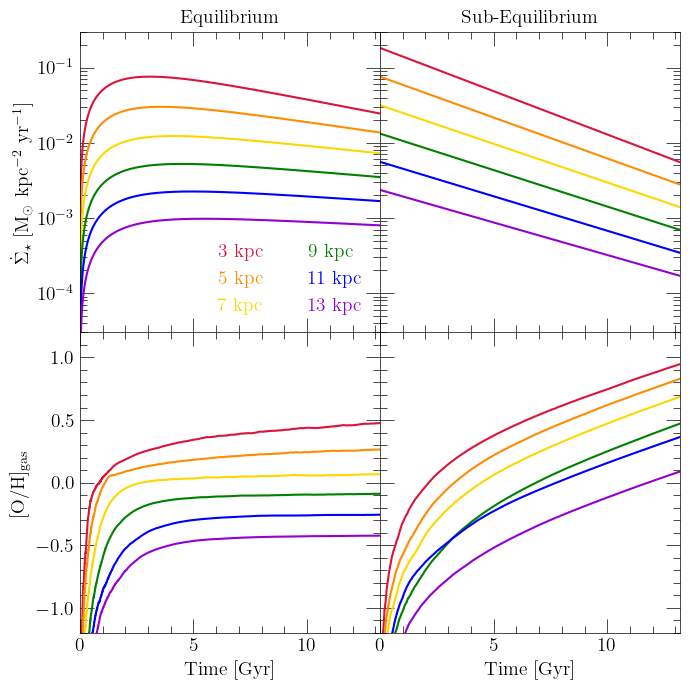

In [6]:
RADII = [3, 5, 7, 9, 11, 13]
COLORS = ["crimson", "darkorange", "gold", "green", "blue", "darkviolet"]
ZONE_WIDTH = 0.1

fig = plt.figure(figsize = (7, 7))
axes = []
for i in range(4):
    kwargs = {}
    if i: kwargs["sharex"] = axes[0]
    if i % 2: kwargs["sharey"] = axes[i - 1]
    else: pass
    axes.append(fig.add_subplot(221 + i, **kwargs))
    axes[i].set_xlim([0, 13.2])
    if i % 2: plt.setp(axes[i].get_yticklabels(), visible = False)
    if i < 2:
        plt.setp(axes[i].get_xticklabels(), visible = False)
        axes[i].set_yscale("log")
    else:
        axes[i].set_xlabel("Time [Gyr]")
axes[0].set_ylabel(r"$\dot{\Sigma}_\star$ [M$_\odot$ kpc$^{-2}$ yr$^{-1}$]")
axes[0].set_ylim([3.e-5, 0.3])
axes[0].set_title("Equilibrium")
axes[1].set_title("Sub-Equilibrium")
axes[2].set_ylabel(r"[O/H]$_\text{gas}$")
axes[2].set_ylim([-1.2, 1.2])

for output, ax1, ax2 in [[eq, axes[0], axes[2]], [subeq, axes[1], axes[3]]]:
    for i in range(len(RADII)):
        zone = int(RADII[i] / ZONE_WIDTH)
        time = output.zones["zone%d" % (zone)].history["time"]
        area = np.pi * ((RADII[i] + ZONE_WIDTH)**2 - RADII[i]**2)
        sfr = [_ / area for _ in output.zones["zone%d" % (zone)].history["sfr"]]
        oh = output.zones["zone%d" % (zone)].history["[o/h]"]
        kwargs = {
            "c": named_colors()[COLORS[i]],
            "label": "%d kpc" % (RADII[i])
        }
        ax1.plot(time, sfr, **kwargs)
        ax2.plot(time, oh, **kwargs)

kwargs = {
    "loc": mpl_loc("lower right"),
    "handlelength": 0,
    "ncol": 2
}
leg = axes[0].legend(**kwargs)
fancy_legend(leg, COLORS)

plt.tight_layout()
plt.subplots_adjust(wspace = 0, hspace = 0)
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./eq-vs-subeq/sfhs.%s" % (ext), **kwargs)
plt.show()

In [3]:
def boxcarsmoothdist(arr, xvals, window):
    dist = len(xvals) * [0.]
    for i in range(len(xvals)):
        within_window = list(filter(lambda x: xvals[i] - window <= x <= xvals[i] + window, arr))
        dist[i] = len(within_window)
    norm = 0
    for i in range(len(dist) - 1): norm += dist[i] * (xvals[i + 1] - xvals[i])
    return [_ / norm for _ in dist]

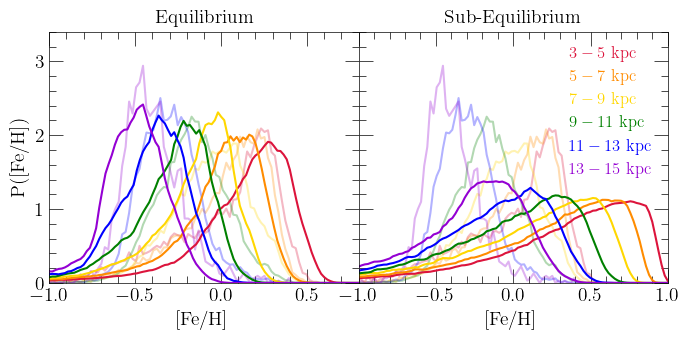

In [9]:
ELEMENT = "fe"
RADIAL_BINS = [3, 5, 7, 9, 11, 13, 15]
COLORS = ["crimson", "darkorange", "gold", "green", "blue", "darkviolet"]
ZONE_WIDTH = 0.1

fig = plt.figure(figsize = (7, 3.5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, sharey = ax1)
for ax in [ax1, ax2]:
    ax.set_xlabel(r"[%s/H]" % (ELEMENT.capitalize()))
ax1.set_ylabel(r"P([%s/H])" % (ELEMENT.capitalize()))
plt.setp(ax2.get_yticklabels(), visible = False)
ax1.set_xlim([-1, 0.8])
ax1.set_ylim([0, 3.4])
ax1.set_yticks([0, 1, 2, 3])
ax2.set_xlim([-1, 1])
ax1.set_title("Equilibrium")
ax2.set_title("Sub-Equilibrium")

raw = np.genfromtxt("./empirical/%sh-dists.out" % (ELEMENT.lower()))
for i in range(len(RADIAL_BINS) - 1):
    xvals = []
    yvals = []
    for j in range(len(raw)):
        if abs(raw[j][0] - RADIAL_BINS[i]) < 0.1:
            xvals.append(raw[j][2])
            yvals.append(raw[j][3])
        else: pass
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "alpha": 0.3
    }
    ax1.plot(xvals, yvals, **kwargs)
    ax2.plot(xvals, yvals, **kwargs)

for stars, ax in [[eq_stars, ax1], [subeq_stars, ax2]]:
    xvals = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 100)
    for i in range(len(RADIAL_BINS) - 1):
        sub = stars.filter(
            "zone_final", ">=", int(RADIAL_BINS[i] / ZONE_WIDTH)).filter(
            "zone_final", "<=", int(RADIAL_BINS[i + 1] / ZONE_WIDTH) - 1)
        dist = boxcarsmoothdist(sub["[%s/h]" % (ELEMENT.lower())], xvals, 0.03)
        kwargs = {
            "c": named_colors()[COLORS[i]],
            "label": r"$%d - %d$ kpc" % (RADIAL_BINS[i], RADIAL_BINS[i + 1])
        }
        ax.plot(xvals, dist, **kwargs)

kwargs = {
    "loc": mpl_loc("upper right"),
    "columnspacing": 1,
    "handlelength": 0,
    "ncol": 1,
    "fontsize": 12
}
leg = ax2.legend(**kwargs)
fancy_legend(leg, COLORS)

plt.tight_layout()
plt.subplots_adjust(wspace = 0)
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./eq-vs-subeq/%sh-dists-datacomp.%s" % (ELEMENT.lower(), ext), **kwargs)
plt.show()

i = 9    
i = 9    


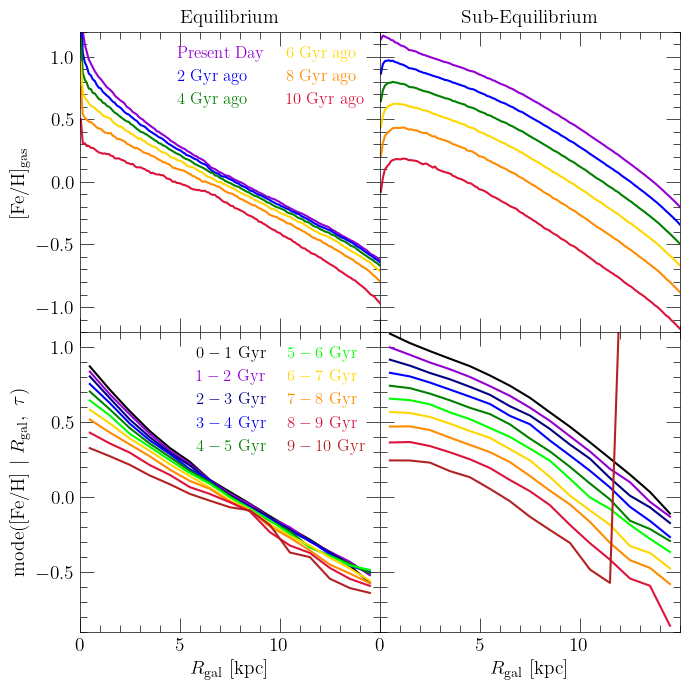

In [72]:
ELEMENT = "fe"
ZONE_WIDTH = 0.1
GAS_SNAPSHOTS = [0, 2, 4, 6, 8, 10]
GAS_COLORS = ["darkviolet", "blue", "green", "gold", "darkorange", "crimson"]
RADIAL_BINS = list(range(16))
AGE_BINS = list(range(11))
STAR_COLORS = ["black", "darkviolet", "navy", "blue", "green", "lime", "gold", "darkorange", "crimson", "firebrick"]

fig = plt.figure(figsize = (7, 7))
axes = []
for i in range(4):
    kwargs = {}
    if i: kwargs["sharex"] = axes[0]
    if i % 2: kwargs["sharey"] = axes[i - 1]
    axes.append(fig.add_subplot(221 + i, **kwargs))
    if i % 2:
        plt.setp(axes[i].get_yticklabels(), visible = False)
    else: pass
    if i < 2:
        plt.setp(axes[i].get_xticklabels(), visible = False)
    else:
        axes[i].set_xlabel(r"$R_\text{gal}$ [kpc]")
    axes[i].set_xlim([0, 15])
    axes[i].set_xticks([0, 5, 10])
axes[0].set_ylabel(r"[%s/H]$_\text{gas}$" % (ELEMENT.capitalize()))
axes[2].set_ylabel(r"mode([%s/H] $|\ R_\text{gal},\ \tau$)" % (ELEMENT.capitalize()))
axes[0].set_ylim([-1.2, 1.2])
axes[0].set_yticks([-1, -0.5, 0, 0.5, 1])
axes[2].set_ylim([-0.9, 1.1])
axes[2].set_yticks([-0.5, 0, 0.5, 1])
axes[0].set_title("Equilibrium")
axes[1].set_title("Sub-Equilibrium")

for output, ax in [[eq, axes[0]], [subeq, axes[1]]]:
    radii = [ZONE_WIDTH * (i + 0.5) for i in range(len(output.zones.keys()))]
    for i in range(len(GAS_SNAPSHOTS)):
        lookback = output.zones["zone0"].history["lookback"]
        diff = [abs(_ - GAS_SNAPSHOTS[i]) for _ in lookback]
        idx = diff.index(min(diff))
        gas = []
        for j in range(len(output.zones.keys())): gas.append(
            output.zones["zone%d" % (j)].history["[%s/h]" % (ELEMENT)][idx])
        kwargs = {"c": named_colors()[GAS_COLORS[i]]}
        if GAS_SNAPSHOTS[i]:
            kwargs["label"] = "%d Gyr ago" % (GAS_SNAPSHOTS[i])
        else:
            kwargs["label"] = "Present Day"
        ax.plot(radii, gas, **kwargs)

for stars, ax in [[eq_stars, axes[2]], [subeq_stars, axes[3]]]:
    centers = [(a + b) / 2 for a, b in zip(RADIAL_BINS[:-1], RADIAL_BINS[1:])]
    for i in range(len(AGE_BINS) - 1):
        sys.stdout.write("\ri = %d    " % (i))
        yvals = []
        sub = stars.filter(
            "age", ">=", AGE_BINS[i]).filter(
            "age", "<=", AGE_BINS[i + 1])
        for j in range(len(RADIAL_BINS) - 1):
            subsub = sub.filter(
                "zone_final", ">=", int(RADIAL_BINS[j] / ZONE_WIDTH)).filter(
                "zone_final", "<=", int(RADIAL_BINS[j + 1] / ZONE_WIDTH) - 1)
            yvals.append(skewnormal_mode_sample(subsub["[%s/h]" % (ELEMENT.lower())]))
        kwargs = {
            "c": named_colors()[STAR_COLORS[i]],
            "label": r"$%d - %d$ Gyr" % (AGE_BINS[i], AGE_BINS[i + 1])
        }
        ax.plot(centers, yvals, **kwargs)
    sys.stdout.write("\n")

kwargs = {
    "loc": mpl_loc("upper right"),
    "columnspacing": 1,
    "handlelength": 0,
    "ncol": 2,
    "fontsize": 12
}
leg = axes[0].legend(**kwargs)
fancy_legend(leg, GAS_COLORS)

leg = axes[2].legend(**kwargs)
fancy_legend(leg, STAR_COLORS)

plt.tight_layout()
plt.subplots_adjust(hspace = 0, wspace = 0)
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./eq-vs-subeq/%sh-gradients-gas-and-stars.%s" % (ELEMENT.lower(), ext), **kwargs)
plt.show()